In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
sns.set()

In [2]:
df = pd.read_csv("../data/data_csv.csv")

In [3]:
df["Year"] = pd.DatetimeIndex(df['Date']).year 

In [4]:
vif = pd.DataFrame()
df_vif = df.drop("Date", axis=1)
vif["features"] = df_vif.columns
vif["vif_Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

print(vif)
print("\nIf VIF value is higher than 10, it is usually considered having high correlation with other independent variables.")

               features  vif_Factor
0                 SP500  381.962424
1              Dividend  288.972458
2              Earnings  144.001576
3  Consumer Price Index   40.233282
4    Long Interest Rate   11.172129
5            Real Price  386.726001
6         Real Dividend  293.661481
7         Real Earnings  163.017104
8                  PE10   48.355051
9                  Year   68.838492

If VIF value is higher than 10, it is usually considered having high correlation with other independent variables.


### To calculate real returns we use the formula:
return[t] = return[t-1] * (((Real Price[t] - Real Price[t-1]) / Real Price[t-1])) + 1) + (Real Dividend[t-1]/RealPrice[t-1])

In [5]:
def calculate_real_return(start_year, end_year, previous_return, df_s):
    df_new_s = df_s[(df_s["Year"] >= start_year) & (df_s["Year"] < end_year)].reset_index(drop=True)
    
    diff_price = ((df_new_s["Real Price"].values[-1] - df_new_s["Real Price"].values[0]) / (df_new_s["Real Price"].values[0])) + 1
    cum_return = previous_return * diff_price
    reinvested_dividens = cum_return + (df_new_s["Real Dividend"].values[0] / df_new_s["Real Price"].values[0])

    return reinvested_dividens

In [6]:
start_y = 2000
end_y = 2018

previous_real_returns = []
previous_real_returns.append(1) # start with investing one dollar at the begining
i = 0

for y in range(start_y, end_y):
    real_return = calculate_real_return(y, y+1, previous_real_returns[i], df) 
    previous_real_returns.append(real_return)
    i += 1

In [7]:
return_val = []
year = start_y
i = 0
year_count = []

df_new = df[df.Year>=start_y].reset_index(drop=True)

for idx, row in df_new.iterrows():
    if row.Year == year:
        return_val.append(previous_real_returns[i])
        year_count.append(i)
    else:
        year += 1
        i += 1
        return_val.append(previous_real_returns[i])
        year_count.append(i)

In [8]:
df_new = df_new.drop("Date", axis=1)
df_new["Return"] = return_val
df_new["InvestedYears"] = year_count

(array([ 7., 16., 30., 63., 30., 15., 24., 19.,  8.,  4.]),
 array([ 889.28 , 1070.365, 1251.45 , 1432.535, 1613.62 , 1794.705,
        1975.79 , 2156.875, 2337.96 , 2519.045, 2700.13 ]),
 <a list of 10 Patch objects>)

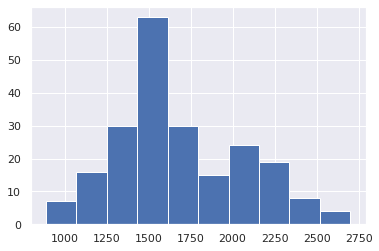

In [9]:
plt.hist(df_new["Real Price"])

(array([24., 24., 24., 12., 24., 24., 12., 24., 24., 24.]),
 array([ 0. ,  1.7,  3.4,  5.1,  6.8,  8.5, 10.2, 11.9, 13.6, 15.3, 17. ]),
 <a list of 10 Patch objects>)

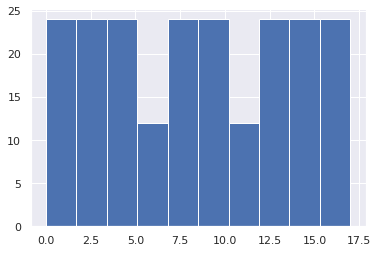

In [10]:
plt.hist(df_new["InvestedYears"])

(array([20., 36., 55., 45.,  9.,  8., 21., 11.,  7.,  4.]),
 array([ 757.13 ,  947.851, 1138.572, 1329.293, 1520.014, 1710.735,
        1901.456, 2092.177, 2282.898, 2473.619, 2664.34 ]),
 <a list of 10 Patch objects>)

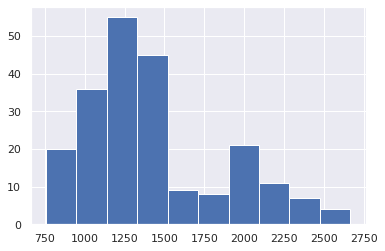

In [11]:
plt.hist(df_new["SP500"])

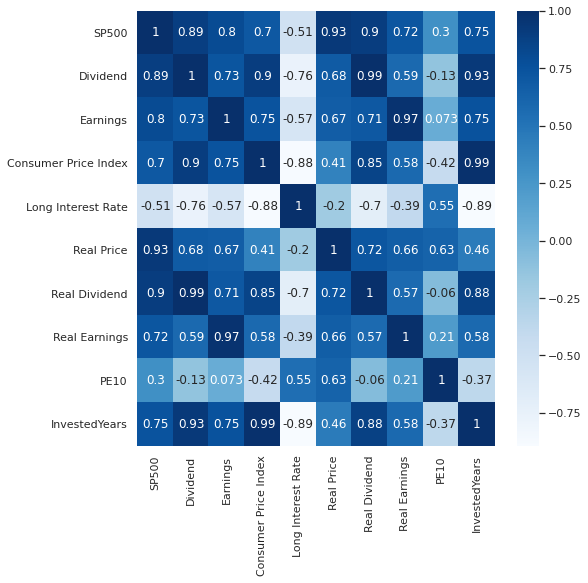

select those independent variables with high correlation with dependent variable


In [12]:
plt.figure(figsize=(8, 8))
sns.heatmap(df_new.drop(["Return", "Year"], axis=1).corr(), annot=True, cmap=plt.cm.Blues)
plt.show()

print("select those independent variables with high correlation with dependent variable")

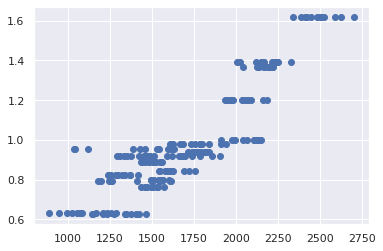

In [13]:
plt.scatter(df_new["Real Price"], df_new["Return"])

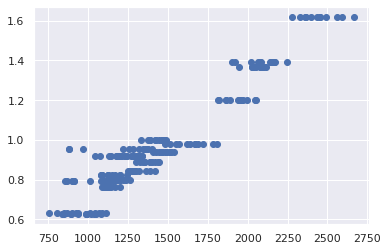

In [14]:
plt.scatter(df_new["SP500"], df_new["Return"])

In [15]:
returns = [math.log(r) for r in df_new["Return"]]

Text(0, 0.5, 'Return')

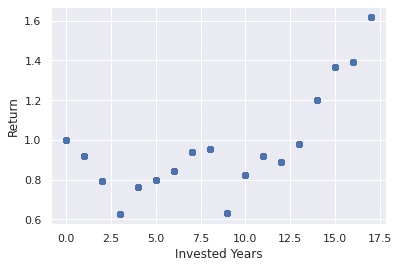

In [16]:
plt.scatter(df_new["InvestedYears"], df_new["Return"])
plt.xlabel("Invested Years")
plt.ylabel("Return")

Text(0, 0.5, 'Log Return')

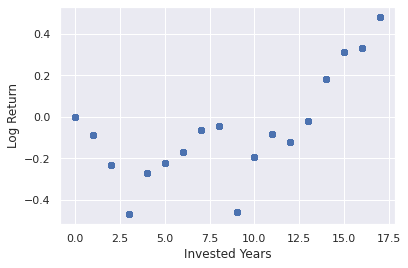

In [17]:
plt.scatter(df_new["InvestedYears"], returns)
plt.xlabel("Invested Years")
plt.ylabel("Log Return")

/home/tamara/.pyenv/versions/3.8.3/envs/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


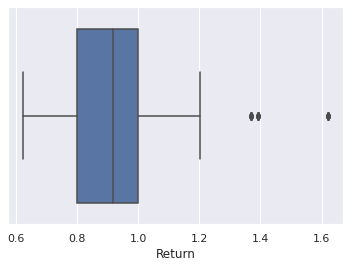

In [18]:
sns.boxplot(df_new["Return"])

In [19]:
vif = pd.DataFrame()
df_vif = df_new[["SP500", "Real Price"]]
vif["features"] = df_vif.columns
vif["vif_Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

print(vif)
print("\nIf VIF value is higher than 10, it is usually considered having high correlation with other independent variables.")

     features  vif_Factor
0       SP500   74.213667
1  Real Price   74.213667

If VIF value is higher than 10, it is usually considered having high correlation with other independent variables.


In [20]:
def get_cv_scores(model, x, y):
    scores = cross_val_score(model, x, y, cv=10, scoring='r2')
    
    print(f'CV Mean: {np.mean(scores):.4f}')
    print(f'STD: {np.std(scores):.4f}')

In [21]:
def results(y_t, y_p):
    print(f'Mean squared error: {mean_squared_error(y_t, y_p):.4f}')
    # The coefficient of determination: 1 is perfect prediction
    print(f'Coefficient of determination: {r2_score(y_t, y_p):.4f}')

### Model 1: Return ~ SP500

In [22]:
X = df_new[["SP500"]]
y = df_new[["Return"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

lr = LinearRegression().fit(X_train, y_train)

print("**** Results ****")
get_cv_scores(lr, X_train, y_train)

y_pred = lr.predict(X_test)
results(y_test, y_pred)

**** Results ****
CV Mean: 0.8946
STD: 0.0347
Mean squared error: 0.0080
Coefficient of determination: 0.8988


### Model 2: Return ~ InvestedYears

In [23]:
X = df_new[["InvestedYears"]]
y = df_new[["Return"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

lr = LinearRegression().fit(X_train, y_train)

print("**** Results ****")
get_cv_scores(lr, X_train, y_train)

y_pred = lr.predict(X_test)
results(y_test, y_pred)

**** Results ****
CV Mean: 0.3781
STD: 0.1660
Mean squared error: 0.0360
Coefficient of determination: 0.5430


### Model 3: Return ~ SP500 + InvestedYears

In [39]:
X = df_new[["SP500", "InvestedYears"]]
y = df_new[["Return"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

lr = LinearRegression().fit(X_train, y_train)

print("**** Results ****")
get_cv_scores(lr, X_train, y_train)

y_pred = lr.predict(X_test)
results(y_test, y_pred)

**** Results ****
CV Mean: 0.8938
STD: 0.0349
Mean squared error: 0.0080
Coefficient of determination: 0.8990


### Model 4: Return ~ All features

In [25]:
y = df_new[["Return"]]
X = df_new.drop("Return", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

lr = LinearRegression().fit(X_train, y_train)

print("**** Results ****")
get_cv_scores(lr, X_train, y_train)

y_pred = lr.predict(X_test)
results(y_test, y_pred)

**** Results ****
CV Mean: 0.9130
STD: 0.0437
Mean squared error: 0.0054
Coefficient of determination: 0.9310


In [26]:
X_train_sm = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_sm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     228.1
Date:                Wed, 21 Oct 2020   Prob (F-statistic):           8.97e-86
Time:                        13:54:55   Log-Likelihood:                 219.43
No. Observations:                 162   AIC:                            -416.9
Df Residuals:                     151   BIC:                            -382.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.886e-06   5.25e-06     -0.359      0.720   -1.23e-05    8.49e-06
SP500                   -0.0004      0.001     -0.569      0.570      -0.002       0.001
Dividend                 0.1511      0.044      3.408      0.001       0.064       0.239
Earnings                 0.0079      0.006      1.316      0.190      -0.004       0.020
Consumer Price Index    -0.0123      0.003     -4.656      0.000      -0.017      -0.007
Long Interest Rate       0.0479      0.015      3.208      0.002       0.018       0.077
Real Price            3.659e-05      0.001      0.055      0.956      -0.001       0.001
Real Dividend           -0.1135      0.041     -2.801      0.006      -0.194      -0.033
Real Earnings           -0.0053      0.005     -1.038      0.301      -0.015       0.005
PE10                     0.0224      0.012      1.796      0.074      -0.002       0.047
Year                     0.0013      0.000      4.712      0.000       0.001       0.002
InvestedYears            0.0050      0.011      0.477      0.634      -0.016       0.026
==============================================================================
Omnibus:                        1.910   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.385   Jarque-Bera (JB):                1.493
Skew:                          -0.149   Prob(JB):                        0.474
Kurtosis:                       3.363   Cond. No.                     1.04e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.37e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### From results above we could see that feature "Invested Years" doesn't improve our model so we could exclude it in future analysis.

## Using PCA to transform features

In [27]:
def transform_features(num_components, X_tr, X_te):
    scaler = MinMaxScaler()
    X_train_minmax = scaler.fit_transform(X_tr)
    X_test_minmax = scaler.transform(X_te)
    
    pca = PCA(n_components=num_components)
    X_train_pca = pca.fit_transform(X_train_minmax)
    X_test_pca = pca.transform(X_test_minmax)
    return pca, X_train_pca, X_test_pca

In [28]:
y = df_new[["Return"]]
X = df_new.drop("Return", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

pca, X_train_pca, X_test_pca = transform_features(0.99, X_train, X_test)

lr = LinearRegression().fit(X_train_pca, y_train)
print("**** Results ****")
get_cv_scores(lr, X_train_pca, y_train)

y_pred = lr.predict(X_test_pca)
results(y_test, y_pred)

**** Results ****
CV Mean: 0.8988
STD: 0.0286
Mean squared error: 0.0061
Coefficient of determination: 0.9220


In [29]:
X_train_sm = sm.add_constant(X_train_pca)
model = sm.OLS(y_train, X_train_sm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     443.6
Date:                Wed, 21 Oct 2020   Prob (F-statistic):           1.99e-84
Time:                        13:54:55   Log-Likelihood:                 197.62
No. Observations:                 162   AIC:                            -385.2
Df Residuals:                     157   BIC:                            -369.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9745      0.006    170.897      0.000       0.963       0.986
x1             0.2684      0.008     35.386      0.000       0.253       0.283
x2            -0.3161      0.017    -18.916      0.000      -0.349      -0.283
x3             0.3104      0.025     12.367      0.000       0.261       0.360
x4            -0.2004      0.059     -3.403      0.001      -0.317      -0.084
==============================================================================
Omnibus:                        2.870   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.238   Jarque-Bera (JB):                2.503
Skew:                           0.296   Prob(JB):                        0.286
Kurtosis:                       3.139   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

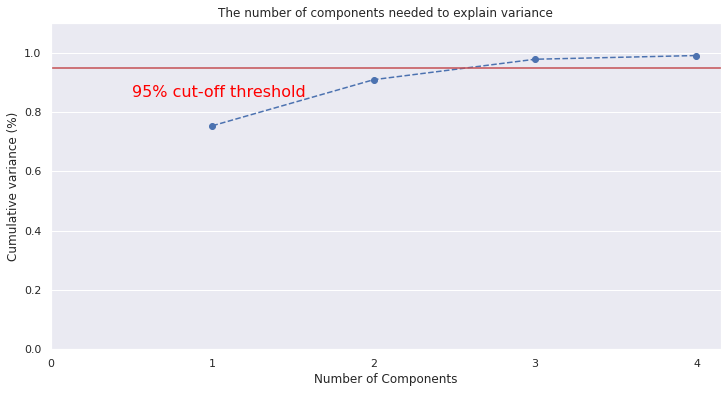

In [30]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
end_d = 6 if start_y != 2000 else 5
xi = np.arange(1, end_d, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, end_d, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

### From the plot above we could see that we need 3 components to expalin variance.

### Model 5: Return ~ PCA  with 3 components

In [31]:
y = df_new[["Return"]]
X = df_new.drop("Return", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

pca, X_train_pca, X_test_pca = transform_features(3, X_train, X_test) # try with 3 components

lr = LinearRegression().fit(X_train_pca, y_train)
print("**** Results ****")
get_cv_scores(lr, X_train_pca, y_train)

y_pred = lr.predict(X_test_pca)
results(y_test, y_pred)

**** Results ****
CV Mean: 0.8905
STD: 0.0427
Mean squared error: 0.0065
Coefficient of determination: 0.9172


In [32]:
X_train_sm = sm.add_constant(X_train_pca)
model = sm.OLS(y_train, X_train_sm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     550.8
Date:                Wed, 21 Oct 2020   Prob (F-statistic):           2.07e-83
Time:                        13:54:55   Log-Likelihood:                 191.85
No. Observations:                 162   AIC:                            -375.7
Df Residuals:                     158   BIC:                            -363.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9745      0.006    165.446      0.000       0.963       0.986
x1             0.2684      0.008     34.257      0.000       0.253       0.284
x2            -0.3161      0.017    -18.313      0.000      -0.350      -0.282
x3             0.3104      0.026     11.972      0.000       0.259       0.362
==============================================================================
Omnibus:                        1.150   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.563   Jarque-Bera (JB):                1.250
Skew:                           0.184   Prob(JB):                        0.535
Kurtosis:                       2.777   Cond. No.                         4.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
y_pred.tolist()
y_pred_list = [i[0] for i in y_pred.tolist()]

Text(0, 0.5, 'Return')

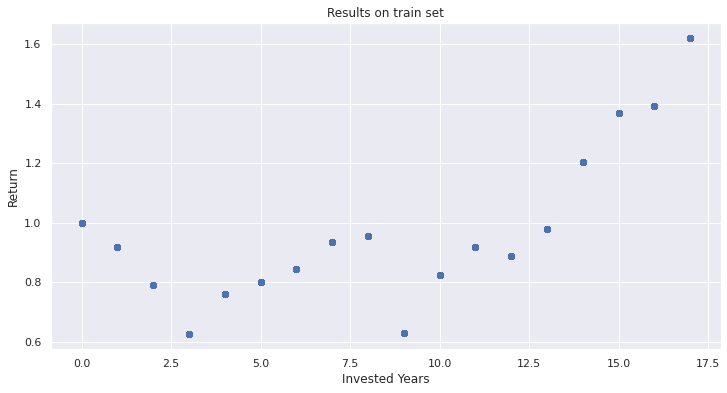

In [34]:
plt.scatter(list(X_train["InvestedYears"]), list(y_train.Return))
plt.title("Results on train set")
plt.xlabel("Invested Years")
plt.ylabel("Return")

Text(0, 0.5, 'Return')

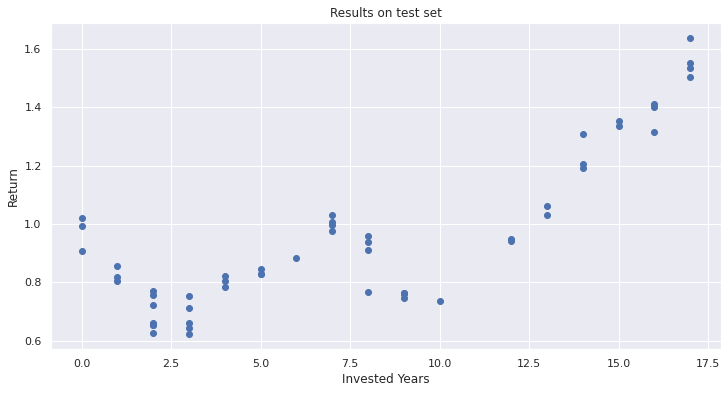

In [35]:
plt.scatter(list(X_test["InvestedYears"]), y_pred_list)
plt.title("Results on test set")
plt.xlabel("Invested Years")
plt.ylabel("Return")

In [36]:
updated_df = pd.read_csv("../data/U.S. Stock Markets 1871-Present.csv")

years = []
for idx, row in updated_df.iterrows():
    years.append(int(str(row["Date"]).split('.')[0]))
    
updated_df["Year"] = years

# we don't have whole year in 2020 so we exclude 2020
start_y = 2018
end_y = 2020
updated_df = updated_df[(updated_df["Year"] >= start_y) & (updated_df["Year"] < end_y)].reset_index(drop=True)

updated_df.drop("Date", axis=1, inplace=True)
updated_df = updated_df.drop(["RealTRScaledEarnings", "Real Total Return Price"], axis=1)

In [37]:
previous_real_returns = []
previous_real_returns.append(1) # start with investing one dollar at the begining
i = 0

for y in range(start_y, end_y):
    real_return = calculate_real_return(y, y+1, previous_real_returns[i], updated_df) 
    previous_real_returns.append(real_return)
    i += 1

return_val = []
year = start_y
i = 0
year_count = []

for idx, row in updated_df.iterrows():
    if row.Year == year:
        return_val.append(previous_real_returns[i])
        year_count.append(i)
    else:
        year += 1
        i += 1
        return_val.append(previous_real_returns[i])
        year_count.append(i)

In [38]:
updated_df["Return"] = return_val
updated_df["InvestedYears"] = year_count
updated_df = updated_df.drop("Year", axis=1)

y = updated_df[["Return"]]
X = updated_df.drop("Return", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

pca, X_train_pca, X_test_pca = transform_features(3, X_train, X_test) # try with 3 components

lr = LinearRegression().fit(X_train_pca, y_train)
print("**** Results ****")
y_pred = lr.predict(X_test_pca)
results(y_test, y_pred)

**** Results ****
Mean squared error: 0.0000
Coefficient of determination: 0.9369
